# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [3]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [4]:
from PIL import Image
sizes = [Image.open(dog_file).size for dog_file in dog_files]

In [9]:
np_sizes = np.array(sizes)
x = np_sizes[:,0]
y = np_sizes[:,1]

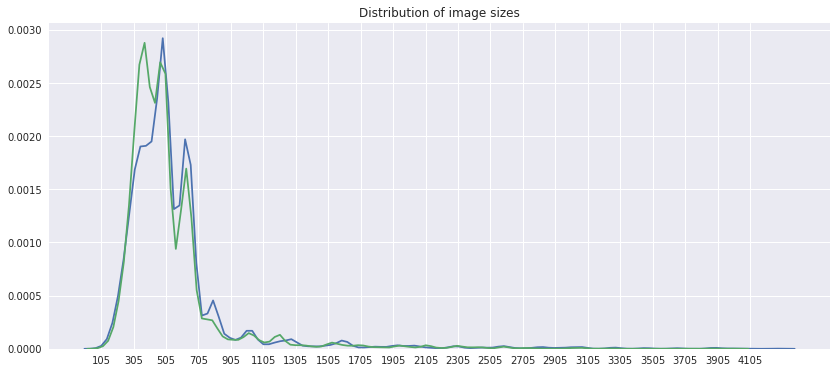

In [10]:
import matplotlib.pyplot as plt                        
%matplotlib inline     
import seaborn as sns; sns.set(color_codes=True)

plt.figure(figsize=(14, 6))
plt.xticks(np.arange(min(x), max(x)+1, 200.0))
sns.kdeplot(x)
sns.kdeplot(y)
plt.title('Distribution of image sizes')
plt.show()

8

/data/dog_images/train/050.Chinese_shar-pei/Chinese_shar-pei_03587.jpg


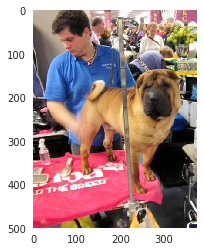

/data/dog_images/train/036.Briard/Briard_02552.jpg


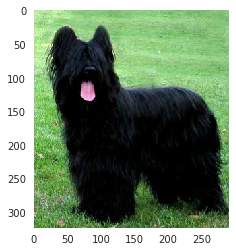

/data/dog_images/train/035.Boykin_spaniel/Boykin_spaniel_02440.jpg


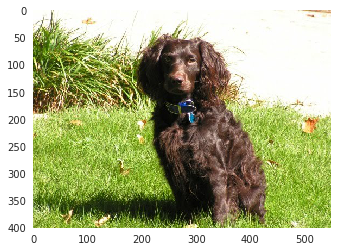

/data/dog_images/train/006.American_eskimo_dog/American_eskimo_dog_00399.jpg


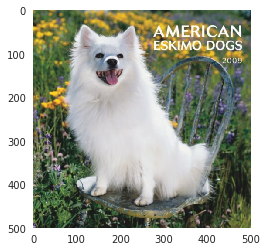

/data/dog_images/train/056.Dachshund/Dachshund_03941.jpg


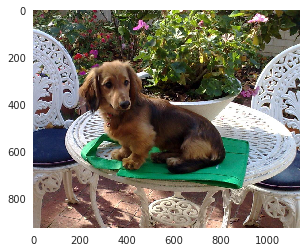

In [26]:
import matplotlib.pyplot as plt
import random

dog_files_train = np.array(glob("/data/dog_images/train/*/*"))
n_images = len(dog_files_train)

for _ in range(5) :
    file = dog_files_train[random.randrange(n_images)]
    print(file)
    img = Image.open(file)
    plt.grid(b=None)
    plt.imshow(img)
    plt.pause(0.001)

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


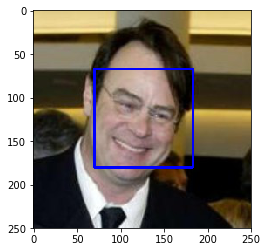

In [45]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [40]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

98% human images were detected as human faces

17% dog images were detected as human faces

In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

print('True positive: {}'.format(len([True for human in human_files_short if face_detector(human)]) / len(human_files_short)))
print('False positive: {}'.format(len([True for dog in dog_files_short if face_detector(dog)]) / len(dog_files_short)))

True positive: 0.98
False positive: 0.17


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [6]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [41]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 100587035.01it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [42]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform_pipeline = transforms.Compose([transforms.Resize(256),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor(), 
                                             normalize])
    img = Image.open(img_path)
    img = transform_pipeline(img)
    img = img.unsqueeze(0)
    img = img.to('cuda')
    
    VGG16.eval()

    prediction = VGG16(img)
    _, index = torch.max(prediction, 1)
    
    return index[0] # predicted class index

In [8]:
VGG16_predict(dog_files_short[0]) in range(151, 268)

True

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [43]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.    
    return VGG16_predict(img_path) in range(151, 268) # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [10]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
print('True positive: {}'.format(len([True for dog in dog_files_short if dog_detector(dog)]) / len(dog_files_short)))
print('False positive: {}'.format(len([True for human in human_files_short if dog_detector(human)]) / len(human_files_short)))

True positive: 1.0
False positive: 0.0


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [11]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [28]:
import numpy as np
from torchvision import datasets
import torch
from PIL import ImageFile
import torchvision.transforms as transforms
import matplotlib.pyplot as plt                        
%matplotlib inline    

ImageFile.LOAD_TRUNCATED_IMAGES = True


# check if CUDA is available
use_cuda = torch.cuda.is_available()

In [ ]:
def get_class_counts(data_loader) :
    labels = [label  for _, labels_tensor in data_loader for label in labels_tensor.tolist()]
    classes, counts = np.unique(labels, return_counts=True)
    return labels, classes, counts

train_data_loader = torch.utils.data.DataLoader(datasets.ImageFolder('/data/dog_images/train', 
                                                transform=transforms.Compose([transforms.ToTensor()])))
                                                
labels, classes, counts = get_class_counts(train_data_loader)

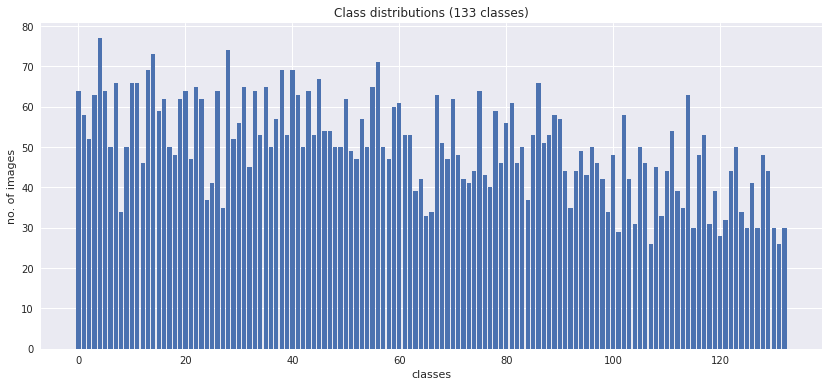

In [62]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(classes, counts)
ax.set_title('Class distributions (133 classes)')
ax.set_xlabel('classes')
ax.set_ylabel('no. of images')
plt.show()

In [30]:
# calculate weights           
weights = 1.0 / torch.tensor(counts, dtype=torch.float)
sample_weights = weights[labels]

In [64]:
import os

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_data_loader = torch.utils.data.DataLoader(datasets.ImageFolder('/data/dog_images/train', 
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(56),
                                                    transforms.RandomHorizontalFlip(),
                                                    transforms.ToTensor(), 
                                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])),
                                                sampler=torch.utils.data.sampler.WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True),
                                                batch_size=4)
valid_data_loader = torch.utils.data.DataLoader(datasets.ImageFolder('/data/dog_images/valid', transform=
                                                transforms.Compose([
                                                    transforms.Resize(64),
                                                    transforms.CenterCrop(56),
                                                    transforms.ToTensor(), 
                                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])),
                                                batch_size=4,
                                                shuffle=True)
test_data_loader = torch.utils.data.DataLoader(datasets.ImageFolder('/data/dog_images/test', transform=
                                               transforms.Compose([
                                                    transforms.Resize(64),
                                                    transforms.CenterCrop(56),
                                                   transforms.ToTensor(), 
                                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])),
                                               batch_size=4,
                                               shuffle=True)

loaders_scratch = {'train': list(train_data_loader), 'valid': list(valid_data_loader), 'test': list(test_data_loader)}

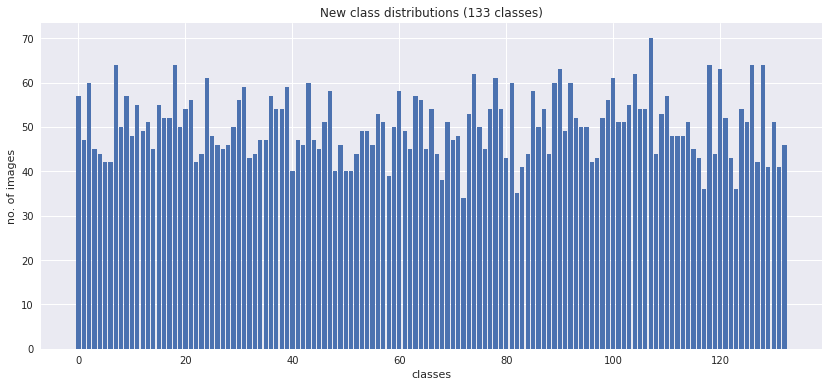

In [65]:
_, classes, counts = get_class_counts(loaders_scratch['train'])
                                                
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(classes, counts)
ax.set_title('New class distributions (133 classes)')
ax.set_xlabel('classes')
ax.set_ylabel('no. of images')
plt.show()

In [6]:
print('No. of classes: {}'.format(len(train_data_loader.dataset.classes)))

No. of classes: 133


In [7]:
train_data_loader.dataset

Dataset ImageFolder
    Number of datapoints: 6680
    Root Location: /data/dog_images/train
    Transforms (if any): Compose(
                             RandomResizedCrop(size=(56, 56), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [34]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.grid(b=None)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

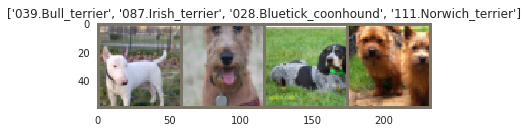

In [37]:
class_names = train_data_loader.dataset.classes

# Get a batch of training data
inputs, classes = next(iter(train_data_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: I resized and chopped the images. I chose 56x56 because it was small enough to train faster and less memory demanding, also big enough to perform well. I thought it would be a good choice.

I used transforms.RandomHorizontalFlip() in the training set to increase variations in the datasets so that it can perform better.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [20]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        #Input channels = 3, output channels = 56        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),  
#             nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 133),
        )
    
    def forward(self, x):
        ## Define forward behavior
        
#         #Computes the activation of the first convolution
#         #Size changes from (3, 224, 224) to (64, 224, 224) to (64, 112, 112)
#         x = self.pool(F.relu(self.conv1(F.relu(self.conv1(x)))))
        
#         #Size changes from (64, 112, 112) to (64, 56, 56)
#         x = self.pool(F.relu(self.conv2(F.relu(self.conv2(x)))))
        
#         #Size changes from (64, 56, 56) to (64, 28, 28)
#         x = self.pool(F.relu(self.conv3(F.relu(self.conv3(x)))))
        
#         #Reshape data to input to the input layer of the neural net
#         #Size changes from (64, 28, 28) to (1, 50176)
#         #Recall that the -1 infers this dimension from the other given dimension
#         x = x.view(-1, x.size(0))
        
#         #Computes the activation of the first fully connected layer
#         #Size changes from (1, 50176) to (1, 4096)
#         x = F.relu(self.fc1(x))
#         #Size changes from (1, 4096) to (1, 1024)
#         x = F.relu(self.fc2(x))
        
#         #Computes the second fully connected layer (activation applied later)
#         #Size changes from (1, 1024) to (1, 133)
#         x = self.fc2(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return(x)

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

INPUT -> (CONV -> ReLU -> POOL)*4 -> (FC -> ReLU -> Dropout)*2 -> FC
1. The input was 56x56x3 (WxHxC). I chose this size because it was small enough to learn quickly and fit in the GPU memory and at the same time, big enough to learn enough features.
2. I had four layers of CONV layer, as I had learnt from VGG's implementation, with a kernel size of 3, stride of 1 to keep every detail in the feature map and zero padding of 1 to avoid details around the boundaries being washed out. Began with a receptive field of 32, 64, 128 and ended with 256 to keep memory footprint as small as possible and at the same time, keep up with the depath of learning.  
3. RELU activation layers to speed up the training time
4. POOL of kernel size of 2 and stride of 2 to reduce feature map sizes and at the same time keeping the performance after each CONV layer.
5. 3 consecutive fully connected layers to reduce the dimensions from (256 * 7 * 7) to 4096 to 133 as defined in the number of classes. 
6. While learning all these, I came across AdaptiveAvgPool that some claimed that it can reduce overlapping in pooling, I thought I might as well put it in and see if it can help.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [21]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [54]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    loss_list = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # Run the forward pass
            outputs = model(data)
            loss = criterion(outputs, target)
            loss_list.append(loss.item())

            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_list.append(loss.item())
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if (valid_loss_min > valid_loss) :
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
#         # monitor test loss and accuracy
#         test_loss = 0.
#         correct = 0.
#         total = 0.
# 
#         model.eval()
#         for batch_idx, (data, target) in enumerate(loaders['test']):
#             # move to GPU
#             if use_cuda:
#                 data, target = data.cuda(), target.cuda()
#             # forward pass: compute predicted outputs by passing inputs to the model
#             output = model(data)
#             # calculate the loss
#             loss = criterion(output, target)
#             # update average test loss 
#             test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
#             # convert output probabilities to predicted class
#             pred = output.data.max(1, keepdim=True)[1]
#             # compare predictions to true label
#             correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
#             total += data.size(0)

#         print('Test Loss: {:.6f}\n'.format(test_loss))

#         print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
#             100. * correct / total, correct, total))
        
#         if (correct / total) > 0.1 :
#             return model
            
    plt.plot(loss_list)
    plt.show()
    
    # return trained model
    return model


In [23]:
# train the model
model_scratch = train(50, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.891129 	Validation Loss: 4.891370
Test Loss: 4.885458


Test Accuracy:  1% (10/836)
Epoch: 2 	Training Loss: 4.871041 	Validation Loss: 4.829424
Test Loss: 4.763174


Test Accuracy:  2% (18/836)
Epoch: 3 	Training Loss: 4.774238 	Validation Loss: 4.699318
Test Loss: 4.625909


Test Accuracy:  2% (23/836)
Epoch: 4 	Training Loss: 4.681614 	Validation Loss: 4.562671
Test Loss: 4.433707


Test Accuracy:  2% (24/836)
Epoch: 5 	Training Loss: 4.557970 	Validation Loss: 4.429679
Test Loss: 4.317843


Test Accuracy:  4% (36/836)
Epoch: 6 	Training Loss: 4.462433 	Validation Loss: 4.327612
Test Loss: 4.222104


Test Accuracy:  5% (46/836)
Epoch: 7 	Training Loss: 4.374973 	Validation Loss: 4.212656
Test Loss: 4.155658


Test Accuracy:  6% (57/836)
Epoch: 8 	Training Loss: 4.281741 	Validation Loss: 4.093850
Test Loss: 4.088883


Test Accuracy:  6% (55/836)
Epoch: 9 	Training Loss: 4.179029 	Validation Loss: 3.953245
Test Loss: 4.013723


Test Accuracy:  7% (65/836)
E

In [24]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [25]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [26]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.947899


Test Accuracy: 10% (88/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [30]:
## TODO: Specify data loaders
import os
from torchvision import datasets
import torch
from PIL import ImageFile
import torchvision.transforms as transforms

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
ImageFile.LOAD_TRUNCATED_IMAGES = True
transform_pipeline = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(), 
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
train_data = datasets.ImageFolder('/data/dog_images/train', transform=transform_pipeline)
train_data_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=4,
                                          shuffle=True)
valid_data = datasets.ImageFolder('/data/dog_images/valid', transform=transform_pipeline)
valid_data_loader = torch.utils.data.DataLoader(valid_data,
                                          batch_size=4,
                                          shuffle=True)
test_data = datasets.ImageFolder('/data/dog_images/test', transform=transform_pipeline)
test_data_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=4,
                                          shuffle=True)

loaders_transfer = {'train': list(train_data_loader), 'valid': list(valid_data_loader), 'test': list(test_data_loader)}
data_transfer = {'train': train_data, 'valid': valid_data, 'test': test_data}

In [31]:
class_names = train_data_loader.dataset.classes

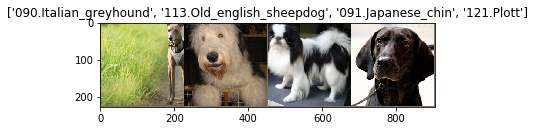

In [34]:
# Get a batch of training data
inputs, classes = next(iter(train_data_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [51]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

## TODO: Specify model architecture 
model_transfer = models.resnet18(pretrained=True)
num_ftrs = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(num_ftrs, len(class_names))

use_cuda = torch.cuda.is_available()

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 76698360.37it/s]


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

1. Load a pretrained model from ResNet.
2. A fully connected layer to reduce the number of features to 'fit' our case, 133.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [52]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.001, momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

Epoch: 1 	Training Loss: 1.077634 	Validation Loss: 2.177175
Epoch: 2 	Training Loss: 0.441670 	Validation Loss: 1.818594
Epoch: 3 	Training Loss: 0.203291 	Validation Loss: 1.419311
Epoch: 4 	Training Loss: 0.114958 	Validation Loss: 0.902239
Epoch: 5 	Training Loss: 0.079298 	Validation Loss: 0.678791
Epoch: 6 	Training Loss: 0.060356 	Validation Loss: 0.386803
Epoch: 7 	Training Loss: 0.042759 	Validation Loss: 0.233343
Epoch: 8 	Training Loss: 0.031932 	Validation Loss: 0.193369
Epoch: 9 	Training Loss: 0.028356 	Validation Loss: 0.007318
Epoch: 10 	Training Loss: 0.013529 	Validation Loss: 0.001638


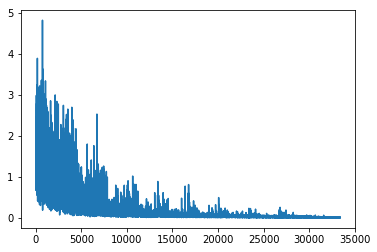

In [55]:
n_epochs = 10

# train the model
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [56]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.746416


Test Accuracy: 81% (683/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [70]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
import glob
from PIL import Image

def predict(model, img_path) :
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    transforms_pipeline = transforms.Compose([transforms.Resize(256),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor(),
                                              normalize
                                         ])    
    data = Image.open(glob.glob(img_path)[0])
    data = transforms_pipeline(data)
    
    if torch.cuda.is_available():
        data = data.cuda()
    
    data.unsqueeze_(0)
    output = model(data)
    # convert output probabilities to predicted class
    pred = output.data.max(1, keepdim=True)[1]
    # compare predictions to true label
    index = np.squeeze(pred).cpu().numpy()
    
    return index

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    index = predict(model_transfer, img_path)
    return class_names[index]

In [71]:
predict_breed_transfer('/data/dog_images/test/103.Mastiff/Mastiff_06873.jpg')

'Mastiff'

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [91]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
from PIL import Image
import matplotlib.pyplot as plt                        
%matplotlib inline                               


def run_app(img_path):
    im = Image.open(img_path)
    plt.imshow(im)
    plt.pause(0.001)  # pause a bit so that plots are updated

    ## handle cases for a human face, dog, and neither
    if (dog_detector(img_path)) :
        print( 'hello doggy, you are a ', predict_breed_transfer(img_path) )
    elif (face_detector(img_path)) :
        print( 'are you a human or a {}?'.format( predict_breed_transfer(img_path) ))
    else :
        print( 'what are you?')
    
    

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement) Yes, it was better than I expected :). very cool. And for improvements, that's what I wanted to know! I have done everything that I could do at this stage to make it run with the memory and time contraints here and perform reasonably well.

Well, I could still think of some possible improvements that I know of in term of my current knowledge.
1. Better ways to handle data imbalancing in training datasets. I wanted to know if they are other ways.
2. Better ways to augment training datasets so that I could get better variations and make the best use of training datasets in hand.
3. Stack more CONV layers before pooling in the first layer to get better learning results I guess.

In [92]:
import numpy as np
import glob

# load filenames for human and dog images
my_files = np.array(glob.glob("my_images/*"))

# print number of images in each dataset
print('There are %d total my images.' % len(my_files))

There are 6 total my images.


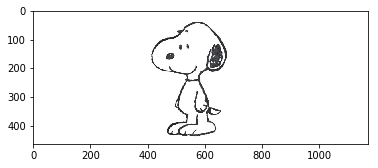

what are you?


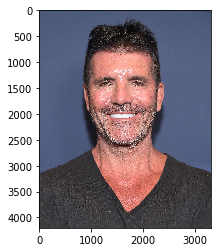

are you a human or a Pharaoh hound?


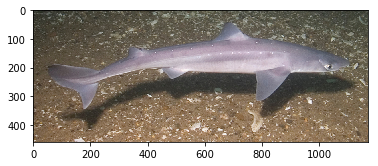

what are you?


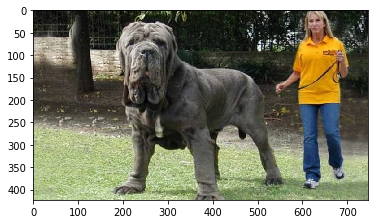

hello doggy, you are a  Neapolitan mastiff


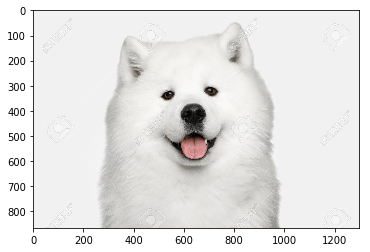

hello doggy, you are a  American eskimo dog


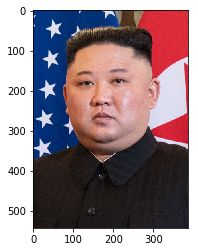

are you a human or a Dogue de bordeaux?


In [93]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((my_files[:])):
    run_app(file)